<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/TestODECoupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")



dolfin version: 2019.1.0


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


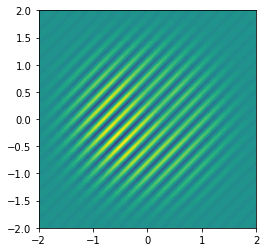

In [30]:
"""
FEniCS tutorial demo program: Diffusion of a Gaussian hill.

  u'= Laplace(u) + f  in a square domain
  u = u_D             on the boundary
  u = u_0             at t = 0

  u_D = f = 0

The initial condition u_0 is chosen as a Gaussian hill.
"""
from scipy.integrate import ode

from __future__ import print_function
from fenics import *
import time

T = 10.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
                 degree=2, a=5)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - u_n*v*dx

K = assemble(dot(grad(u), grad(v))*dx)

def dydt(t, u):
    return (K*u);

def jac(t, u):
    return K.array();

t0 = 0  
r = ode(dydt, jac).set_integrator('zvode', method='bdf', with_jacobian=True)
r.set_initial_value(u_n.vector(), t0)

while r.successful() and r.t < T:
    r.integrate(r.t+dt)
    # print("%g" % r.t); 
    # print(r.y)
    # print("%g %g" % (r.t, r.y))

u=Function(V);    
u.vector()[:]=r.y[:];
plot(u)